In [ ]:
import torch
import torchvision
import numpy as np   
print("✅ Torch:", torch.__version__)
print("✅ TorchVision:", torchvision.__version__)
print("✅ NumPy:", np.__version__)


✅ Torch: 2.7.1+cpu
✅ TorchVision: 0.22.1+cpu
✅ NumPy: 1.26.4


In [13]:
import os
import random
import shutil
from sklearn.model_selection import train_test_split


# Your raw dataset (unbalanced)
DATASET_DIR = r"E:\projects\Plant_DATSET\Plant_Disease_Dataset\train"

# Balanced + split dataset output
OUTPUT_DIR = r"E:\projects\project1\data"
# Desired images per class
TARGET_IMAGES = 1000  

# Split ratios
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.7, 0.2, 0.1

# Create output folders
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(OUTPUT_DIR, split), exist_ok=True)

# Loop through each class
for class_name in os.listdir(DATASET_DIR):
    class_dir = os.path.join(DATASET_DIR, class_name)
    if not os.path.isdir(class_dir):
        continue

    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.lower().endswith((".jpg", ".png", ".jpeg"))]

    # Skip empty folders
    if len(images) == 0:
        print(f"⚠️ Skipping class '{class_name}' (no images found)")
        continue

    # Balance dataset
    if len(images) >= TARGET_IMAGES:
        images = random.sample(images, TARGET_IMAGES)  # downsample
    else:
        repeat_factor = TARGET_IMAGES // len(images)
        remainder = TARGET_IMAGES % len(images)
        images = images * repeat_factor + random.sample(images, remainder)  # oversample

    # Split into train/val/test
    train_imgs, temp_imgs = train_test_split(images, train_size=TRAIN_RATIO, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=TEST_RATIO / (VAL_RATIO + TEST_RATIO), random_state=42)

    # Save files
    for split, split_imgs in zip(["train", "val", "test"], [train_imgs, val_imgs, test_imgs]):
        split_dir = os.path.join(OUTPUT_DIR, split, class_name)
        os.makedirs(split_dir, exist_ok=True)
        for img_path in split_imgs:
            shutil.copy(img_path, os.path.join(split_dir, os.path.basename(img_path)))

    print(f"✅ Class {class_name}: {len(train_imgs)} train, {len(val_imgs)} val, {len(test_imgs)} test")


✅ Class Apple___Apple_scab: 700 train, 200 val, 100 test
✅ Class Apple___Black_rot: 700 train, 200 val, 100 test
✅ Class Apple___Cedar_apple_rust: 700 train, 200 val, 100 test
✅ Class Apple___healthy: 700 train, 200 val, 100 test
✅ Class Blueberry___healthy: 700 train, 200 val, 100 test
✅ Class Cherry_(including_sour)___healthy: 700 train, 200 val, 100 test
✅ Class Cherry_(including_sour)___Powdery_mildew: 700 train, 200 val, 100 test
✅ Class Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 700 train, 200 val, 100 test
✅ Class Corn_(maize)___Common_rust_: 700 train, 200 val, 100 test
✅ Class Corn_(maize)___healthy: 700 train, 200 val, 100 test
✅ Class Corn_(maize)___Northern_Leaf_Blight: 700 train, 200 val, 100 test
✅ Class Grape___Black_rot: 700 train, 200 val, 100 test
✅ Class Grape___Esca_(Black_Measles): 700 train, 200 val, 100 test
✅ Class Grape___healthy: 700 train, 200 val, 100 test
✅ Class Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 700 train, 200 val, 100 test
✅ Class Orang

<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
C:\Users\prave\AppData\Local\Temp\ipykernel_17668\577803930.py:14: SyntaxWarning: invalid escape sequence '\p'
  data_dir ="E:\projects\project1\data"   # change this to your dataset root


Using device: cpu, Num classes = 38


E:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🔄 Loading checkpoint...
Resumed from epoch 10, best val acc: 0.9911

Best val Acc: 0.9911


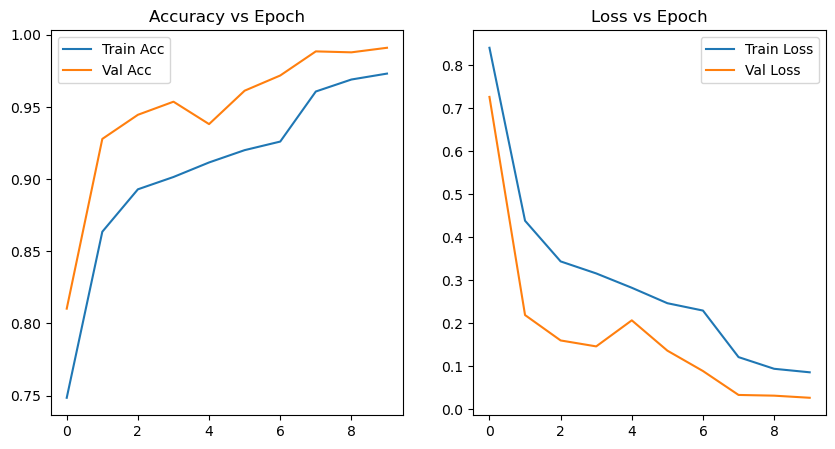

<Figure size 1500x1500 with 0 Axes>

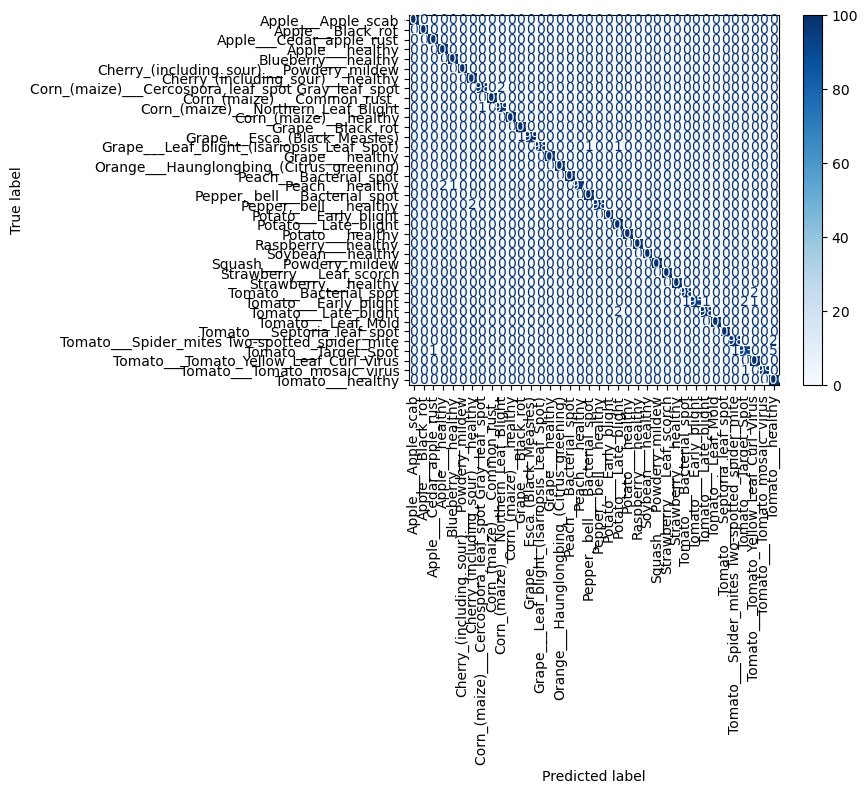

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ===============================
# 1. DATA PREPROCESSING & LOADING
# ===============================
data_dir ="E:\projects\project1\data"   # change this to your dataset root

# augment only train
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# folder must contain train/val/test subfolders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
               for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes
num_classes = len(class_names)   # 38 in your dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}, Num classes = {num_classes}")

# ===============================
# 2. MODEL SETUP
# ===============================
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)   # dynamic class count
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# ===============================
# 3. TRAINING FUNCTION
# ===============================
def train_model(model, criterion, optimizer, scheduler, num_epochs=10, start_epoch=0, checkpoint_path="checkpoint.pth"):
    best_acc = 0.0
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    # Load checkpoint if resuming
    if os.path.exists(checkpoint_path):
        print("🔄 Loading checkpoint...")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_acc = checkpoint['best_acc']
        history = checkpoint['history']
        print(f"Resumed from epoch {start_epoch}, best val acc: {best_acc:.4f}")

    for epoch in range(start_epoch, num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc.item())

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'best_acc': best_acc,
                    'history': history
                }, checkpoint_path)
                print("✅ Best model saved!")

    print(f"\nBest val Acc: {best_acc:.4f}")
    return model, history

# ===============================
# 4. TRAIN FIRST 10 EPOCHS
# ===============================
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=10, checkpoint_path="checkpoint.pth")

# ===============================
# 5. PLOT TRAINING CURVES
# ===============================
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend()
plt.title("Accuracy vs Epoch")

plt.subplot(1,2,2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss vs Epoch")
plt.show()

# ===============================
# 6. EVALUATION ON TEST SET
# ===============================
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(15,15))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.show()


In [5]:
torch.save(model.state_dict(), "best_model.pth")
print("✅ Best model saved as best_model.pth")


✅ Best model saved as best_model.pth


In [6]:
from sklearn.metrics import accuracy_score

test_acc = accuracy_score(all_labels, all_preds)
print(f"📊 Final Test Accuracy: {test_acc:.4f}")


📊 Final Test Accuracy: 0.9921


In [21]:
from torchvision import datasets
import os

# Set your data directory
data_dir = "E:/projects/project1/data"

# Dynamically load class names from training data folder
image_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'))
class_names = image_datasets.classes
num_classes = len(class_names)

# Use this list in your Streamlit code as before
print("Loaded class names for prediction:")
for  class_name in enumerate(class_names):
    print(f" {class_name}")


Loaded class names for prediction:
 (0, 'Apple___Apple_scab')
 (1, 'Apple___Black_rot')
 (2, 'Apple___Cedar_apple_rust')
 (3, 'Apple___healthy')
 (4, 'Blueberry___healthy')
 (5, 'Cherry_(including_sour)___Powdery_mildew')
 (6, 'Cherry_(including_sour)___healthy')
 (7, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot')
 (8, 'Corn_(maize)___Common_rust_')
 (9, 'Corn_(maize)___Northern_Leaf_Blight')
 (10, 'Corn_(maize)___healthy')
 (11, 'Grape___Black_rot')
 (12, 'Grape___Esca_(Black_Measles)')
 (13, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)')
 (14, 'Grape___healthy')
 (15, 'Orange___Haunglongbing_(Citrus_greening)')
 (16, 'Peach___Bacterial_spot')
 (17, 'Peach___healthy')
 (18, 'Pepper,_bell___Bacterial_spot')
 (19, 'Pepper,_bell___healthy')
 (20, 'Potato___Early_blight')
 (21, 'Potato___Late_blight')
 (22, 'Potato___healthy')
 (23, 'Raspberry___healthy')
 (24, 'Soybean___healthy')
 (25, 'Squash___Powdery_mildew')
 (26, 'Strawberry___Leaf_scorch')
 (27, 'Strawberry___healthy')
 (28,